## 第六章 优化算法
### 6.1 优化与深度学习

In [1]:
import d2lzh as d2l
import numpy as np
# 三维画图
from mpl_toolkits import mplot3d

Text(0, 0.5, 'f(x)')

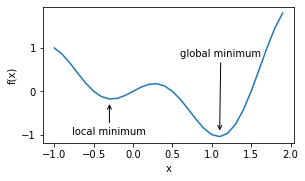

In [2]:
def f(x):
    return x * np.cos(np.pi * x)
d2l.set_figsize((4.5, 2.5))
x = np.arange(-1.0, 2.0, 0.1)
# 逗号表示只取返回列表中的第一个元素
fig, = d2l.plt.plot(x, f(x))
fig.axes.annotate('local minimum', xy=(-0.3, -0.25), xytext=(-0.77, -1.0), arrowprops=dict(arrowstyle='->'))
fig.axes.annotate('global minimum', xy=(1.1, -0.95), xytext=(0.6, 0.8), arrowprops=dict(arrowstyle='->'))
d2l.plt.xlabel('x')
d2l.plt.ylabel('f(x)')

Text(0, 0.5, 'f(x)')

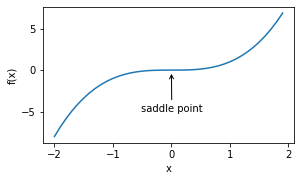

In [3]:
x = np.arange(-2.0, 2.0, 0.1)
fig, = d2l.plt.plot(x, x**3)
fig.axes.annotate('saddle point', xy=(0, -0.2), xytext=(-0.52, -5.0), arrowprops=dict(arrowstyle='->'))
d2l.plt.xlabel('x')
d2l.plt.ylabel('f(x)')

Text(0.5, 0, 'y')

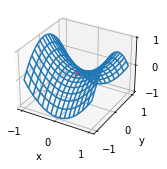

In [7]:
x, y = np.mgrid[-1:1:31j, -1:1:31j]
z = x**2 - y**2
ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 2, 'cstride': 2})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y')

### 6.2 梯度下降和随机梯度下降

In [8]:
import math

In [9]:
def gd(eta):
    x = 10
    results = [x]
    for i in range(10):
        # f(x) = x * x的导数为f'(x) = 2 * x
        x -= eta * 2 * x
        results.append(x)
    print('epoch 10, x:', x)
    return results

In [10]:
res = gd(0.2)

epoch 10, x: 0.06046617599999997


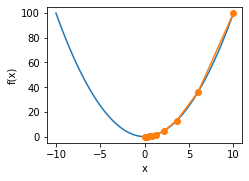

In [11]:
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)), 10)
    # x的取值
    f_line = np.arange(-n, n, 0.1)
    d2l.set_figsize()
    d2l.plt.plot(f_line, [x*x for x in f_line])
    d2l.plt.plot(res, [x*x for x in res], '-o')
    d2l.plt.xlabel('x')
    d2l.plt.ylabel('f(x)')
show_trace(res)

epoch 10, x: 3.4867844009999995


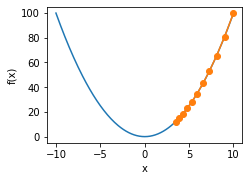

In [12]:
show_trace(gd(0.05))

epoch 10, x: 61.917364224000096


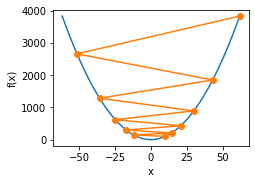

In [13]:
show_trace(gd(1.1))

In [14]:
def train_2d(trainer):
    # s1和s2是自变量状态，本章后续几节会使用
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i+1, x1, x2))
    return results

In [18]:
def show_trace_2d(f, results):
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

epoch 20, x1 -0.057646, x2 -0.000073


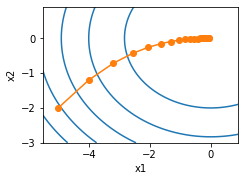

In [19]:
eta = 0.1
# 目标函数
def f_2d(x1, x2):
    return x1**2+2*x2**2
def gd_2d(x1, x2, s1, s2):
    return (x1-eta*2*x1, x2-eta*4*x2, 0, 0)
show_trace_2d(f_2d, train_2d(gd_2d))

epoch 20, x1 -0.108894, x2 0.013042


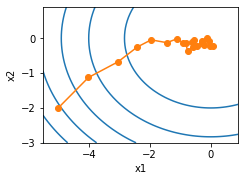

In [20]:
def sgd_2d(x1, x2, s1, s2):
    return (x1-eta*(2*x1+np.random.normal(0.1)), 
            x2-eta*(4*x2+np.random.normal(0.1)), 0, 0)
show_trace_2d(f_2d, train_2d(sgd_2d))

### 6.3 小批量随机梯度下降

In [1]:
import numpy as np
import torch
def get_data_ch7():
    # 数据读取以\t分隔
    data = np.genfromtxt('data/airfoil_self_noise.dat', delimiter='\t')
    # 特征标准化处理
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    # 最后一列是label
    # 前1500个样本(每个样本5个特征)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), torch.tensor(data[:1500, -1], dtype=torch.float32)
features, labels = get_data_ch7()
features.shape

torch.Size([1500, 5])

In [2]:
def sgd(params, states, hyperparms):
    for p in params:
        # 学习率衰减的参数更新
        p.data -= hyperparms['lr'] * p.grad.data

In [3]:
import d2lzh as d2l
import time
def train_ch7(optimizer_fn, states, hyperparams, features, labels, batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = d2l.linreg, d2l.squared_loss
    w = torch.nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32), requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)
    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()
    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            # 使用平均损失
            l = loss(net(X, w, b), y).mean()
            # 梯度清零
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            # 迭代模型参数
            optimizer_fn([w, b], states, hyperparams)
            # 每100个样本记录下当前训练误差
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time()-start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.247478, 0.051707 sec per epoch


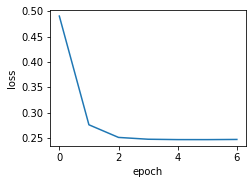

In [4]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)
train_sgd(1, 1500, 6)

loss: 0.243556, 1.291605 sec per epoch


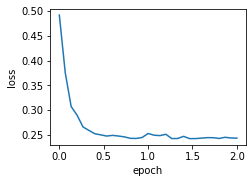

In [5]:
train_sgd(0.005, 1)

loss: 0.246715, 0.133914 sec per epoch


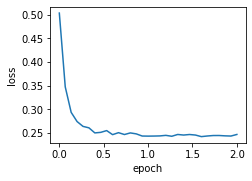

In [6]:
train_sgd(0.05, 10)

In [7]:
import torch.nn as nn
def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams, features, labels, batch_size=10, num_epochs=2):
    # 初始化模型
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)
    def eval_loss():
        return loss(net(features).view(-1), labels).item() / 2
    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True
    )
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            # 除以2是为了和train_ch7保持一致, 因为squared_loss中除了2
            l = loss(net(X).view(-1), y) / 2
            # 梯度清零
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time()-start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.243574, 0.116980 sec per epoch


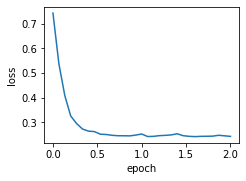

In [8]:
from torch import optim
train_pytorch_ch7(optim.SGD, {'lr': 0.05}, features, labels, 10)

### 6.4 动量法

epoch 20, x1 -0.943467, x2 -0.000073


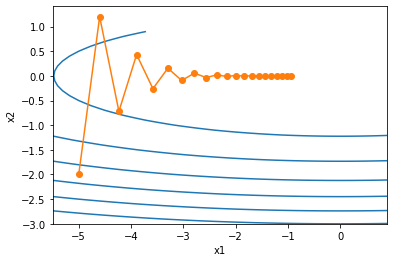

In [1]:
import d2lzh as d2l
# 学习率
eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1-eta*0.2*x1, x2-eta*4*x2, 0, 0)
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

epoch 20, x1 -0.387814, x2 -1673.365109


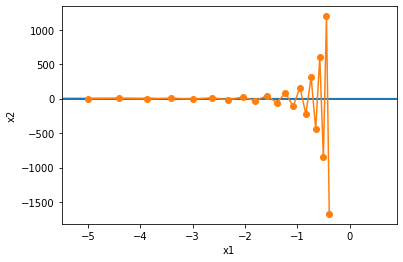

In [2]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

epoch 20, x1 -0.062843, x2 0.001202


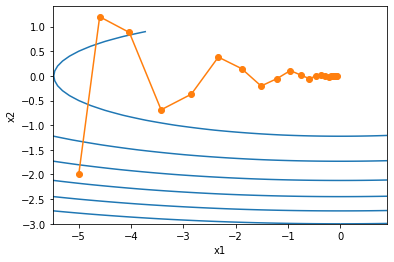

In [3]:
def momentum_2d(x1, x2, v1, v2):
    v1 = gamma * v1 + eta * 0.2 * x1
    v2 = gamma * v2 + eta * 4 * x2
    return x1-v1, x2-v2, v1, v2
eta, gamma = 0.4, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

epoch 20, x1 0.007188, x2 0.002553


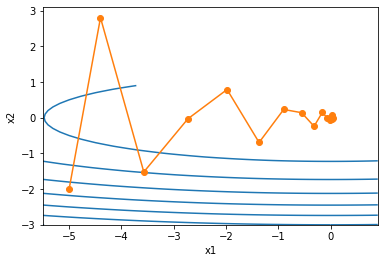

In [4]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

In [5]:
import torch
features, labels = d2l.get_data_ch7()
# 初始化动量相关变量
def init_momentum_states():
    v_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    v_b = torch.zeros(1, dtype=torch.float32)
    return (v_w, v_b)
def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        v.data = hyperparams['momentum']*v.data + hyperparams['lr']*p.grad.data
        p.data -= v.data

loss: 0.243169, 0.260499 sec per epoch


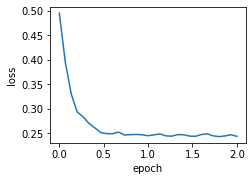

In [6]:
d2l.train_ch7(sgd_momentum, init_momentum_states(), {'lr': 0.02, 'momentum': 0.5}, features, labels)

loss: 0.270185, 0.170542 sec per epoch


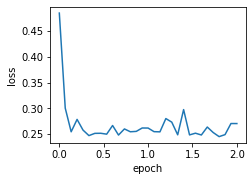

In [7]:
d2l.train_ch7(sgd_momentum, init_momentum_states(), {'lr': 0.02, 'momentum': 0.9}, features, labels)

loss: 0.245188, 0.202992 sec per epoch


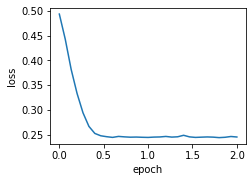

In [8]:
d2l.train_ch7(sgd_momentum, init_momentum_states(), {'lr': 0.004, 'momentum': 0.9}, features, labels)

loss: 0.244982, 0.120022 sec per epoch


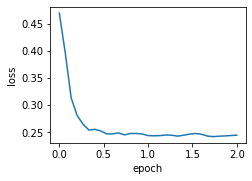

In [9]:
d2l.train_pytorch_ch7(torch.optim.SGD, {'lr': 0.004, 'momentum': 0.9}, features, labels)

### 6.5 AdaGrad算法

epoch 20, x1 -2.382563, x2 -0.158591


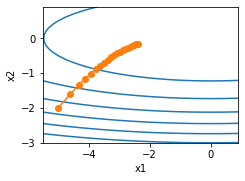

In [11]:
import math
def adagrad_2d(x1, x2, s1, s2):
    # 前两项为自变量梯度
    g1, g2, eps = 0.2*x1, 4*x2, 1e-6
    s1 += g1**2
    s2 += g2**2
    x1 -= eta / math.sqrt(s1+eps)*g1
    x2 -= eta / math.sqrt(s2+eps)*g2
    return x1, x2, s1, s2
def f_2d(x1, x2):
    return 0.1*x1**2+2*x2**2
eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

epoch 20, x1 -0.002295, x2 -0.000000


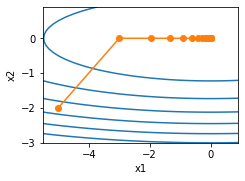

In [12]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

In [15]:
features, labels = d2l.get_data_ch7()
def init_adagrad_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)
def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        s.data += (p.grad.data**2)
        p.data -= hyperparams['lr'] * p.grad.data / torch.sqrt(s+eps)

loss: 0.242391, 0.163231 sec per epoch


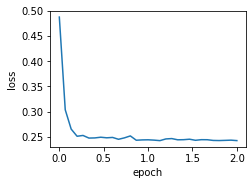

In [16]:
d2l.train_ch7(adagrad, init_adagrad_states(), {'lr': 0.1}, features, labels)

loss: 0.242369, 0.153083 sec per epoch


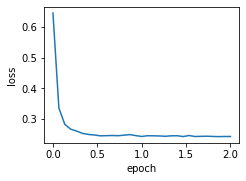

In [17]:
d2l.train_pytorch_ch7(torch.optim.Adagrad, {'lr': 0.1}, features, labels)

### 6.6 RMSProp算法

epoch 20, x1 -0.010599, x2 0.000000


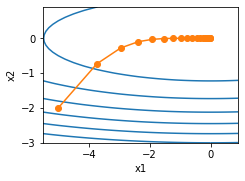

In [18]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2*x1, 4*x2, 1e-6
    s1 = gamma*s1+(1-gamma)*g1**2
    s2 = gamma*s2+(1-gamma)*g2**2
    x1 -= eta / math.sqrt(s1+eps)*g1
    x2 -= eta / math.sqrt(s2+eps)*g2
    return x1, x2, s1, s2
def f_2d(x1, x2):
    return 0.1*x1**2+2*x2**2
eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

In [21]:
features, labels = d2l.get_data_ch7()
def init_rmsprop_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)
def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        s.data = gamma * s.data + (1-gamma) * (p.grad.data)**2
        p.data -= hyperparams['lr']*p.grad.data / torch.sqrt(s+eps)

loss: 0.245565, 0.208567 sec per epoch


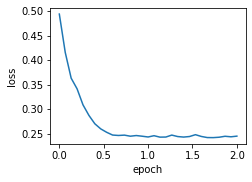

In [22]:
d2l.train_ch7(rmsprop, init_rmsprop_states(), {'lr': 0.01, 'gamma': 0.9}, features, labels)

loss: 0.243149, 0.128298 sec per epoch


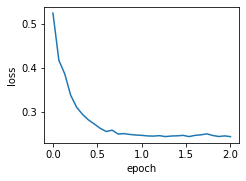

In [23]:
d2l.train_pytorch_ch7(torch.optim.RMSprop, {'lr': 0.01, 'alpha': 0.9}, features, labels)

### 6.7 AdaDelta算法

In [24]:
features, labels = d2l.get_data_ch7()
def init_adadelta_states():
    s_w, s_b = torch.zeros((features.shape[-1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    delta_w, delta_b = torch.zeros((features.shape[-1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((s_w, delta_w), (s_b, delta_b))
def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        s[:] = rho*s+(1-rho)*(p.grad.data**2)
        g = p.grad.data*torch.sqrt((delta+eps)/(s+eps))
        p.data -= g
        delta[:] = rho*delta+(1-rho)*g*g

loss: 0.244431, 0.208847 sec per epoch


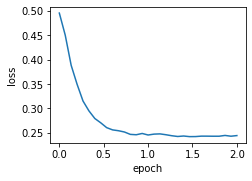

In [25]:
d2l.train_ch7(adadelta, init_adadelta_states(), {'rho': 0.9}, features, labels)

loss: 0.266846, 0.202872 sec per epoch


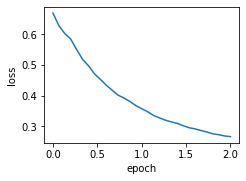

In [26]:
d2l.train_pytorch_ch7(torch.optim.Adadelta, {'rho': 0.9}, features, labels)

### 6.8 Adam算法

In [27]:
features, labels = d2l.get_data_ch7()
def init_adam_states():
    v_w, v_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    s_w, s_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((v_w, s_w), (v_b, s_b))
def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        v[:] = beta1*v + (1-beta1)*p.grad.data
        s[:] = beta2*s + (1-beta2)*p.grad.data**2
        v_bias_corr = v/(1-beta1**hyperparams['t'])
        s_bias_corr = s/(1-beta2**hyperparams['t'])
        p.data -= hyperparams['lr']*v_bias_corr/(torch.sqrt(s_bias_corr)+eps)
    hyperparams['t'] += 1

loss: 0.243669, 0.228965 sec per epoch


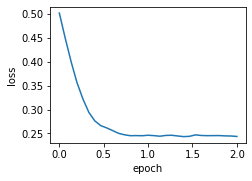

In [28]:
d2l.train_ch7(adam, init_adam_states(), {'lr': 0.01, 't': 1}, features, labels)

loss: 0.243203, 0.139672 sec per epoch


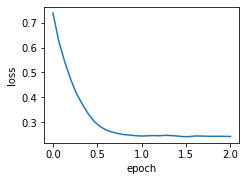

In [29]:
d2l.train_pytorch_ch7(torch.optim.Adam, {'lr': 0.01}, features, labels)